### 1. Initial Setting

In [1]:
!pip install ninja
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
%cd stylegan2-ada-pytorch

     |████████████████████████████████| 112kB 7.3MB/s 
Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 125, done.
remote: Total 125 (delta 0), reused 0 (delta 0), pack-reused 125
Receiving objects: 100% (125/125), 1.12 MiB | 639.00 KiB/s, done.
Resolving deltas: 100% (55/55), done.
/content/stylegan2-ada-pytorch


### 2. Import Libraries

In [76]:
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import dnnlib
import legacy

import PIL
from PIL import Image

import numpy as np

import copy
import pickle
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm



### 3. Define function - image projection (extract w from image)

In [3]:
def projection(img_path):
    img = Image.open(img_path).convert('RGB')
    w, h = img.size
    s = min(w,h)

    #------------------------------#    
    # with open(pkl_path, 'rb') as f:
    #     G = pickle.load(f)['G_ema'].cuda()
    with dnnlib.util.open_url(network_pkl) as f:
        G = legacy.load_network_pkl(f)['G_ema'].to(device) 
    #------------------------------#
    img = img.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    img = img.resize((G.img_resolution, G.img_resolution), PIL.Image.LANCZOS)
    img_uint8 = np.array(img, dtype=np.uint8)
        
    G_eval = copy.deepcopy(G).eval().requires_grad_(False).to(device)

    # Compute w stats
    z_samples = np.random.randn(10000, G_eval.z_dim) # G_eval.z_dim == 512, (10000,512)
    w_samples = G_eval.mapping(torch.from_numpy(z_samples).to(device), None)
    w_samples = w_samples[:,:1,:].cpu().numpy().astype(np.float32)
    w_avg = np.mean(w_samples, axis=0, keepdims=True) 
    w_std = (np.sum((w_samples - w_avg)**2)/10000)**0.5

    # Setup noise inputs
    noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }
        
    # Load VGG16 feature detector
    url = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metrics/vgg16.pt'
    with dnnlib.util.open_url(url) as f:
        vgg16 = torch.jit.load(f).eval().to(device)
    
    # Extract features for target image   

    img_tensor = torch.tensor(img_uint8.transpose([2,0,1]), device=device)
    img_tensor = img_tensor.unsqueeze(0).to(device).to(torch.float32)
    if img_tensor.shape[2] > 256:
        img_tensor = F.interpolate(img_tensor, size=(256,256), mode='area') # Resize to pass through the vgg16 network.
    img_features = vgg16(img_tensor, resize_images=False, return_lpips=True)
    # Set optimizer and Initiate noise
    num_steps = 1000
    initial_learning_rate = 0.1
    # ========================================= #

    w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable
    w_out = torch.zeros([num_steps] + list(w_opt.shape[1:]), dtype=torch.float32, device=device)
    optimizer = torch.optim.Adam([w_opt] + list(noise_bufs.values()), betas=(0.9, 0.999), lr=initial_learning_rate)
    # Init noise.
    for buf in noise_bufs.values():
        buf[:] = torch.randn_like(buf)
        buf.requires_grad = True
    
    # projection
    num_steps = 1000
    lr_rampdown_length = 0.25
    lr_rampup_length = 0.05
    initial_noise_factor = 0.05
    noise_ramp_length = 0.75
    regularize_noise_weight = 1e5
    # ========================================= #

    for step in tqdm(range(num_steps)):
        # Learning rate schedule.
        t = step / num_steps
        w_noise_scale = w_std * initial_noise_factor * max(0.0, 1.0 - t / noise_ramp_length) ** 2
        lr_ramp = min(1.0, (1.0 - t) / lr_rampdown_length)
        lr_ramp = 0.5 - 0.5 * np.cos(lr_ramp * np.pi)
        lr_ramp = lr_ramp * min(1.0, t / lr_rampup_length)
        lr = initial_learning_rate * lr_ramp
        for param_group in optimizer.param_groups:
                param_group['lr'] = lr
                
        # Synthesize image from opt_w
        w_noise = torch.randn_like(w_opt) * w_noise_scale
        ws = (w_opt + w_noise).repeat([1, G.mapping.num_ws, 1])
        synth_images = G.synthesis(ws, noise_mode='const')
        
        # Downsample image to 256x256 if it's larger than that. VGG was built for 224x224 images.
        synth_images = (synth_images + 1) * (255/2)
        if synth_images.shape[2] > 256:
            synth_images = F.interpolate(synth_images, size=(256, 256), mode='area')
            
        # Features for synth images.
        synth_features = vgg16(synth_images, resize_images=False, return_lpips=True)
        dist = (img_features - synth_features).square().sum() # Calculate the difference between two feature maps (target vs synth) generated through vgg. 
                                                                # This is the point of projection.
        # Noise regularization.
        reg_loss = 0.0
        for v in noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        loss = dist + reg_loss * regularize_noise_weight
        
        # Step
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        # if step==0:
        #     print('[{}] projection start - Reproducing the image.. '.format(id))
        # elif (step+1)%100 == 0 and (step+1) != num_steps:
        #     print(f'step {step+1:>4d}/{num_steps}: dist {dist:<4.2f} loss {float(loss):<5.2f}')
        # elif (step+1) == num_steps:
        #     print('projection clear')
        
        # Save projected W for each optimization step.
        w_out[step] = w_opt.detach()[0]

        # Normalize noise.
        with torch.no_grad():
            for buf in noise_bufs.values():
                buf -= buf.mean()
                buf *= buf.square().mean().rsqrt()
    
    projected_w_steps = w_out.repeat([1, G.mapping.num_ws, 1])
    projected_w = projected_w_steps[-1]
    return projected_w

### 4. Define function - image generation (generate image from w)

In [4]:
def generation(w):
    synth_image = G.synthesis(w.unsqueeze(0), noise_mode='const')
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()    
    return synth_image

### 5. Load pre-trained model

In [5]:
network_pkl = 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqdog.pkl'
device = torch.device('cuda')

with dnnlib.util.open_url(network_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].to(device) 

# install plug-in
z = torch.randn([1, G.z_dim]).cuda()
c = None
img = G(z,c) 

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


### 6. Image conversion - 웰시코기 

**6-a. Extract w from each sample image and get new w('age vector')**

In [11]:
before = '../sample_before.png'
after = '../sample_after.png'

w_sample_after = projection(after)
w_sample_before = projection(before)

w = w_sample_after - w_sample_before # extract style
torch.save(w, 'w.pt')

**6-b. Extract w from target image**

In [13]:
target = '../target_before.png'

w_t_b = projection(target)

**6-c. Inject w into target image**

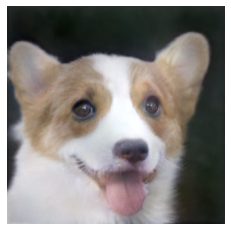

In [18]:
w_t_a = w_t_b + w*0.5 # inject style
gen_target_after = generation(w_t_a) 

img = Image.fromarray(gen_target_after)
plt.imshow(img)
plt.axis('off')
plt.show()

**6-d. Show interpolation**

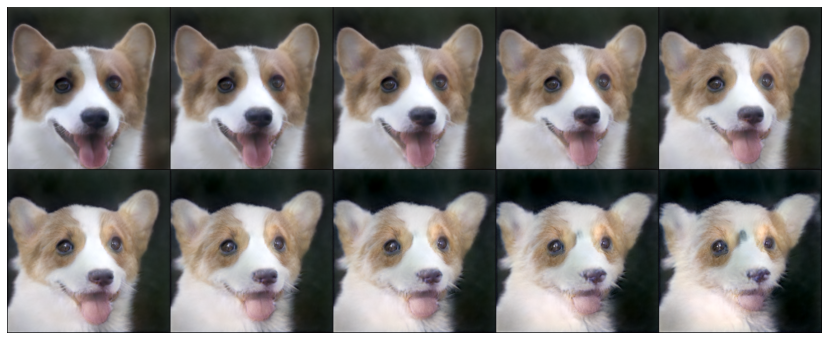

In [106]:
ls = np.linspace(0, 1, 10)
img_list = []
for i in ls:
    w_target_after = w_t_b + w*i
    img = generation(w_target_after)
    img_list.append(img)    

imgs = torch.from_numpy(np.concatenate(img_list))
imgs = imgs.view(10,512,512,3)
imgs = imgs.permute(0,3,1,2)
imgs_grid = torchvision.utils.make_grid(imgs, nrow=5)

plt.figure(figsize=(16,6))
plt.imshow(imgs_grid.permute(1,2,0))
plt.axis('off')
plt.show()

### 7. Image conversion - 시바견

**7-a. Extract w from each sample image and get new w('age vector')**

In [107]:
before = '../sample_before_siba.png'
after = '../sample_after_siba.png'

w_sample_after = projection(after)
w_sample_before = projection(before)

w = w_sample_after - w_sample_before # extract style
torch.save(w, '../w_siba.pt')

**7-b. Extract w from target image**

In [112]:
target = '../target_before_siba.png'

w_t_b = projection(target)

**7-c. Show interpolation**

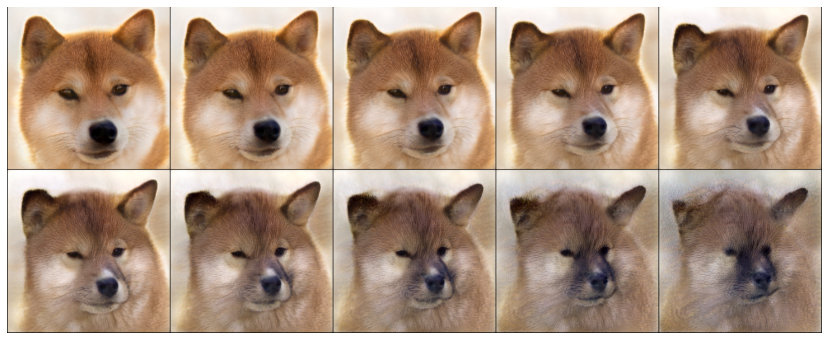

In [113]:
ls = np.linspace(0, 1, 10)
img_list = []
for i in ls:
    w_target_after = w_t_b + w*i
    img = generation(w_target_after)
    img_list.append(img)    

imgs = torch.from_numpy(np.concatenate(img_list))
imgs = imgs.view(10,512,512,3)
imgs = imgs.permute(0,3,1,2)
imgs_grid = torchvision.utils.make_grid(imgs, nrow=5)

plt.figure(figsize=(16,6))
plt.imshow(imgs_grid.permute(1,2,0))
plt.axis('off')
plt.show()

### 8. Image conversion - 요크셔

**8-a. Extract w from each sample image and get new w('age vector')**

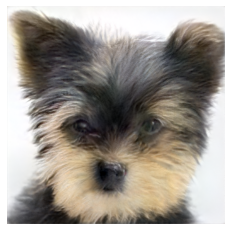

In [25]:
after = '../sample_after_york.png'

w_sample_after = projection(after)

plt.imshow(torch.from_numpy(generation(w_sample_after)))
plt.axis('off')
plt.show()

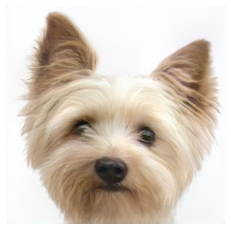

In [30]:
before = '../sample_before_york.png'

w_sample_before = projection(before)

plt.imshow(torch.from_numpy(generation(w_sample_before)))
plt.axis('off')
plt.show()

**8-b. Extract w from target image**

In [88]:
w = w_sample_after - w_sample_before # extract style
torch.save(w, '../w_york.pt')

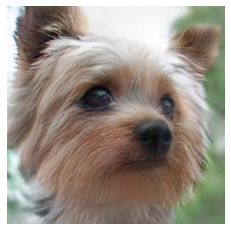

In [82]:
target = '../target_before_york.png'

w_target_before = projection(target)

plt.imshow(torch.from_numpy(generation(w_target_before)))
plt.axis('off')
plt.show()

**8-c. Show interpolation**

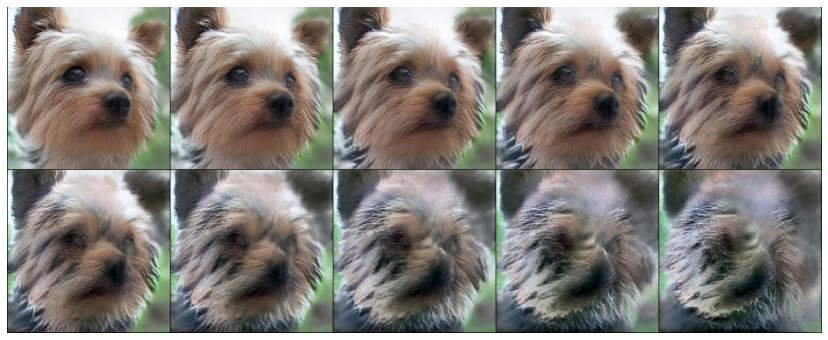

In [89]:
ls = np.linspace(0, 1, 10)
img_list = []
for i in ls:
    w_target_after = w_target_before + w*i
    img = generation(w_target_after)
    img_list.append(img)    

imgs = torch.from_numpy(np.concatenate(img_list))
imgs = imgs.view(10,512,512,3)
imgs = imgs.permute(0,3,1,2)
imgs_grid = torchvision.utils.make_grid(imgs, nrow=5)

plt.figure(figsize=(16,6))
plt.imshow(imgs_grid.permute(1,2,0))
plt.axis('off')
plt.show()

### 9. 반려견의 성장하는 모습 복원?

**9-a. Show interpolation (Preview)**

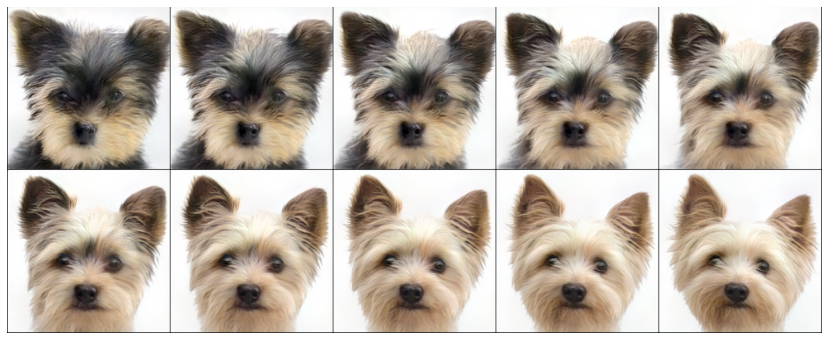

In [91]:
ls = np.linspace(0, 1, 10)
img_list = []
for i in ls:
    w = w_sample_before*(i) + w_sample_after*(1-i)
    img = generation(w)
    img_list.append(img)    

imgs = torch.from_numpy(np.concatenate(img_list))
imgs = imgs.view(10,512,512,3)
imgs = imgs.permute(0,3,1,2)
imgs_grid = torchvision.utils.make_grid(imgs, nrow=5)

plt.figure(figsize=(16,6))
plt.imshow(imgs_grid.permute(1,2,0))
plt.axis('off')
plt.show()

**9-b. Video production**

In [69]:
ls = np.linspace(0, 1, 100)
img_list = []
for i in ls:
    w = w_sample_before*(i) + w_sample_after*(1-i)
    img = generation(w)
    img_list.append(img)

In [67]:
img_list[0].shape

(512, 512, 3)

In [73]:
import imageio

#video = imageio.get_writer('../proj.mp4', mode='I', fps=10, codec='libx264', bitrate='16M')
video = imageio.get_writer('../proj.gif', mode='I', fps=10,)
print (f'Saving optimization progress video "../proj.gif"')
for img in img_list:
    video.append_data(img)
video.close()

Saving optimization progress video "../proj.gif"
